<a href="https://colab.research.google.com/github/nbht98/attack_cat_or_dog_classification/blob/master/TEST_CIFAR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install mia

  Created wheel for mia: filename=mia-0.1.2-cp36-none-any.whl size=11079 sha256=d9285ffe673e16e68f22351baab0701aaf43ffb180f055766c1a8a12c872094a
  Stored in directory: /root/.cache/pip/wheels/e8/83/e4/baae7782aa0d2e45af485d25a7994bab3f76428e483252ce82
Successfully built mia


In [0]:
# Import library 
import numpy as np

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data


In [0]:
NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3

TARGET_EPOCHS = 100 # Number of epochs to train target and shadow models
ATTACK_EPOCHS = 100 # Number of epochs to train attack models.
NUM_SHADOWS = 3 # Number of epochs to train attack models.

In [0]:
def get_data():
    """Prepare CIFAR10 data."""
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    X_train = X_train.astype("float32")
    X_test = X_test.astype("float32")
    y_train = y_train.astype("float32")
    y_test = y_test.astype("float32")
    X_train /= 255
    X_test /= 255
    return (X_train, y_train), (X_test, y_test)


In [0]:
def target_model_fn():
  """The architecture of the target (victim) model.
  The attack is white-box, hence the attacker is assumed to know this architecture too."""

  model = tf.keras.models.Sequential()

  model.add(
      layers.Conv2D(
          32,
          (3, 3),
          activation="relu",
          padding="same",
          input_shape=(WIDTH, HEIGHT, CHANNELS),
      )
  )
  model.add(layers.Conv2D(32, (3, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
  model.add(layers.Conv2D(64, (3, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
  model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model


def attack_model_fn():
  """Attack model that takes target model predictions and predicts membership.
  Following the original paper, this attack model is specific to the class of the input.
  AttachModelBundle creates multiple instances of this model for each class.
  """
  model = tf.keras.models.Sequential()

  model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

  model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
  model.add(layers.Dense(64, activation="relu"))

  model.add(layers.Dense(1, activation="sigmoid"))
  model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
  return model


In [10]:
(X_train, y_train), (X_test, y_test) = get_data()

170500096/170498071 [==============================] - 13s 0us/step


In [17]:
# Train the target model.
print("Training the target model...")
target_model = target_model_fn()
target_model.load_weights("model900.h5")

Training the target model...


In [0]:
target_model.fit(
    X_train, y_train, epochs=TARGET_EPOCHS, validation_split=0.1, verbose=True
)

Epoch 1/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2448 - accuracy: 0.9216 - val_loss: 0.8413 - val_accuracy: 0.8072
Epoch 2/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2450 - accuracy: 0.9225 - val_loss: 0.8545 - val_accuracy: 0.8016
Epoch 3/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2306 - accuracy: 0.9266 - val_loss: 0.8969 - val_accuracy: 0.7968
Epoch 4/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2427 - accuracy: 0.9241 - val_loss: 0.9124 - val_accuracy: 0.8002
Epoch 5/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2463 - accuracy: 0.9226 - val_loss: 0.9072 - val_accuracy: 0.8098
Epoch 6/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2384 - accuracy: 0.9257 - val_loss: 0.9480 - val_accuracy: 0.8036
Epoch 7/300
1407/1407 [==============================] - 8s 6ms/step - loss: 0.2552 - accuracy: 0.9222 - val_loss: 0.8429 - val_ac

In [0]:
target_model.save('model900.h5')

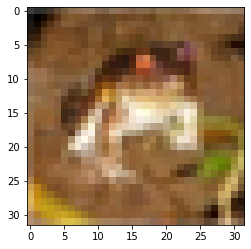

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.squeeze(X_train[0]))


In [0]:
def rand_array(x, k, in_channels, img_size):
    total_num = in_channels * img_size * img_size
    x = x.reshape(1, -1)
    idx_to_modify = np.random.randint(low=0, high=total_num-1, size=(k,))
    gen = np.random.rand(k)
    x[0, idx_to_modify] = gen
    x = x.reshape(img_size, img_size, in_channels)
    return x

In [0]:
def data_synthesize(target_model, fixed_cls, k_max,
                    in_channels, img_size):
    x = np.random.rand(32,32,3)

    y_c_current = 0         # target models probability of fixed class
    j = 0                   # consecutive rejections counter
    k = k_max               # search radius
    max_iter = 50           # max iter number
    conf_min = 0.1          # min probability cutoff to consider a record member of the class
    rej_max = 5             # max number of consecutive rejections
    k_min = 1               # min radius of feature perturbation

    for i in range(max_iter):
        y = target_model.predict(x.reshape(1,32,32,3))  # query target model
        y_c = y.flat[fixed_cls]
        # Phase 1: Search
        if y_c >= y_c_current:
            # Phase 2: Sample
            if (y_c > conf_min) and (fixed_cls == np.argmax(y)):
                return (x, y)
            x_new = x
            y_c_current = y_c  # renew variables
            j = 0
        else:
            j += 1
            if j > rej_max:  # many consecutive rejects
                k = max(k_min, int(np.ceil(k / 2)))
                j = 0
        x_tmp = rand_array(x_new, k, in_channels, img_size)
    return False

In [0]:
while True:
  data = data_synthesize(target_model, fixed_cls=8, k_max=3*32*32-1,
                    in_channels=3, img_size=32)
  if isinstance(data, tuple):
    break
 
print("########## Example ##########")
print("x = ", data[0])
print("y_c = ", data[1])



In [0]:
from numpy import savetxt
def synthesize_batch(target_model, lst_class, n_records):
    """
    Synthesize a batch of records
    """
    x_synth = np.zeros((n_records,32,32,3))
    y_synth = np.zeros((n_records, 10))
    count = 0
    for i in range(n_records//10):
      for j in lst_class:
        while True:
            data = data_synthesize(target_model, fixed_cls=j, k_max=3*32*32-1,
                          in_channels=3, img_size=32)
            if isinstance(data, tuple):
                break
      
        x_synth[count] = data[0]
        y_synth[count] = data[1]
        count += 1
      if (i % 10 == 0 and i != 0):
          np.savez('data' + str(i) +'.npz', x=x_synth, y=y_synth)
          print('data'+ str(i) +' has been saved')
    return x_synth, y_synth

In [30]:
attack_data = synthesize_batch(target_model, [0,1,2,3,4,5,6,7,8,9], 1000)

data10 has been saved
data20 has been saved
data30 has been saved
data40 has been saved
data50 has been saved
data60 has been saved
data70 has been saved
data80 has been saved
data90 has been saved


In [0]:
np.savez('data100.npz', x=attack_data[0], y=attack_data[1])

In [0]:
from numpy import load 
a_d = np.load('data100.npz')

In [50]:
# We assume that attacker's data were not seen in target's training.
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    a_d['x'], a_d['y'], test_size=0.1
)
print(attacker_X_train.shape, attacker_X_test.shape)

(900, 32, 32, 3) (100, 32, 32, 3)


In [0]:
SHADOW_DATASET_SIZE = 450

# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=NUM_SHADOWS,
)

In [75]:
print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=100,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test),
    ),
)

Training the shadow models...
Epoch 1/100
15/15 [==============================] - 0s 16ms/step - loss: 2.2680 - accuracy: 0.0956 - val_loss: 2.2585 - val_accuracy: 0.1000
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2406 - accuracy: 0.0956 - val_loss: 2.2554 - val_accuracy: 0.1000
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2474 - accuracy: 0.0956 - val_loss: 2.2511 - val_accuracy: 0.1000
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2602 - accuracy: 0.0956 - val_loss: 2.2554 - val_accuracy: 0.1000
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2481 - accuracy: 0.0956 - val_loss: 2.2558 - val_accuracy: 0.1000
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2353 - accuracy: 0.0956 - val_loss: 2.2572 - val_accuracy: 0.1000
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 2.2468 - accuracy: 0.0956 - val_loss: 2.2589 - val

In [76]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=20, verbose=True)
)

Training the attack models...
Epoch 1/20
9/9 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.6989
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.8853
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.8889
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.5262 - accuracy: 0.8781
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8996
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.3383 - accuracy: 0.9068
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.9104
Epoch 8/20
9/9 [==============================] - 0s 3ms/step - loss: 0.2398 - accuracy: 0.9068
Epoch 9/20
9/9 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.9068
Epoch 10/20
9/9 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9032
Epoch 11/

In [77]:
# Test the success of the attack.
ATTACK_TEST_DATASET_SIZE = 4000
# Prepare examples that were in the training, and out of the training.
data_in = X_train[:ATTACK_TEST_DATASET_SIZE], y_train[:ATTACK_TEST_DATASET_SIZE]
data_out = X_test[:ATTACK_TEST_DATASET_SIZE], y_test[:ATTACK_TEST_DATASET_SIZE]
# data_out = np.concatenate((X_test, a_X_train), axis=0), np.concatenate((y_test, a_y_train), axis=0)


# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    target_model, data_in, data_out
)

# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_accuracy = np.mean(attack_guesses == real_membership_labels)
print(attack_accuracy)


0.555625
